In [1]:
# 사용할 패키지를 import합니다
import sys
print('python', sys.version)

import numpy as np
import pandas as pd
import matplotlib as mpl

import glob
import pickle
import matplotlib.pyplot as plt
plt.rc("font", family="Malgun Gothic") # window
plt.rc("axes", unicode_minus=False) # x,y축 (-)부호 표시

import seaborn as sns

# 결과 확인을 용이하게 하기 위한 코드
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from sklearn.model_selection import train_test_split
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
#from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix


python 3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]


# XGBoost modeling

In [2]:
def XGBoost(X_train, X_test, y_train, y_test):
    # Create XGBoost classifer object
    xgb = XGBClassifier()

    # Train XGBoost Classifer
    model=xgb.fit(X_train, y_train)

    # Predict the response for test dataset
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)

    # Model Accuracy, how often is the classifier correct?
    APR=metrics.average_precision_score(y_test, y_pred_prob[:,1], average='weighted')
    AUC=metrics.roc_auc_score(y_test, y_pred_prob[:,1])

    return APR, AUC, list(model.feature_names_in_), list(model.feature_importances_)

## AUC with Sig genes

In [ ]:
mer_table = pickle.load(open("D:/jmjung/n_stage_pred_BRCA/mid_result/merged_data/BRCA.pickle", 'rb'))
sig_info = pickle.load(open("D:/jmjung/n_stage_pred_BRCA/main_result/BRCA_sig_info.pickle", 'rb'))

jj=0
res_AUC_sigGenes=pd.DataFrame(columns=['epval','iter','APR','AUC'])
for epval in [0.001, 0.005,0.01]:
    sig_genes=sig_info.loc[epval]['sig_genes']
    
    ## X, y preparation
    X=mer_table.drop(columns='class')
    ## sig gene selection
    X=X[sig_genes]
    
    y=mer_table['class']

    for it in range(50):
        ## split traing and test data
        X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, stratify=y)

        ## machine learning model: (XGBoost)
        APR, AUC, FTN, FTI=XGBoost(X_train, X_test, y_train, y_test)
        res_AUC_sigGenes.loc[jj]=[epval, it, APR, AUC]
        jj+=1
    
res_AUC_sigGenes
res_AUC_sigGenes.groupby('epval')['AUC'].mean()
#pickle.dump(res_AUC_sigGenes, open('D:/jmjung/n_stage_pred_BRCA/main_result/AUC_with_sigGenes.pickle', 'wb'))

## AUC with random genes as many as Sig genes

In [ ]:
mer_table = pickle.load(open("D:/jmjung/n_stage_pred_BRCA/mid_result/merged_data/BRCA.pickle", 'rb'))
ccle_genes=list(pd.read_table('D:/jmjung/n_stage_pred_BRCA/data/ccle_gene_list.txt')['gene'])
shared_cols=list(set(mer_table.columns)&set(ccle_genes))+['class']
mer_table=mer_table[shared_cols]

sig_info = pickle.load(open("D:/jmjung/n_stage_pred_BRCA/main_result/BRCA_sig_info.pickle", 'rb'))

jj=0
res_AUC_ranGenes=pd.DataFrame(columns=['epval','iter','APR','AUC'])
for epval in [0.001, 0.005,0.01]:
    sig_genes=sig_info.loc[epval]['sig_genes']
    num_genes=len(sig_genes)
    
    for it in range(1000):
        ## X, y preparation
        X=mer_table.drop(columns='class')
        ## sig gene selection
        X=X.sample(n=num_genes, axis=1)

        y=mer_table['class']
    
        ## split traing and test data
        X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, stratify=y)

        ## machine learning model: (XGBoost)
        APR, AUC, FTN, FTI=XGBoost(X_train, X_test, y_train, y_test)
        res_AUC_ranGenes.loc[jj]=[epval, it, APR, AUC]
        jj+=1
        
        epval, it
        
res_AUC_ranGenes
#pickle.dump(res_AUC_ranGenes, open('D:/jmjung/n_stage_pred_BRCA/main_result/AUC_with_ranGenes.pickle', 'wb'))

# Fig 3

In [3]:
def display_col_barplot(nsig_df, ax):
    
    nsig_sr=nsig_df['num_of_sig']
    
    ## plot bar
    nsig_sr.plot.bar(ax=ax, color='lightcoral', width=0.9, rot=0, edgecolor='k')
    
    for x, val in enumerate(nsig_sr):
        _=ax.text(x, val, val, ha='center', va='bottom', fontsize=20)
    _=ax.set_ylim(0,400)  
    

epval
0.001    0.745770
0.005    0.776069
0.010    0.765826
Name: AUC, dtype: float64

<AxesSubplot:xlabel='epval', ylabel='AUC'>

<AxesSubplot:xlabel='epval', ylabel='AUC'>

Text(0.01, 1.02, '(a)')

Text(0.35, 1.02, '(b)')

Text(0.7, 1.02, '(c)')

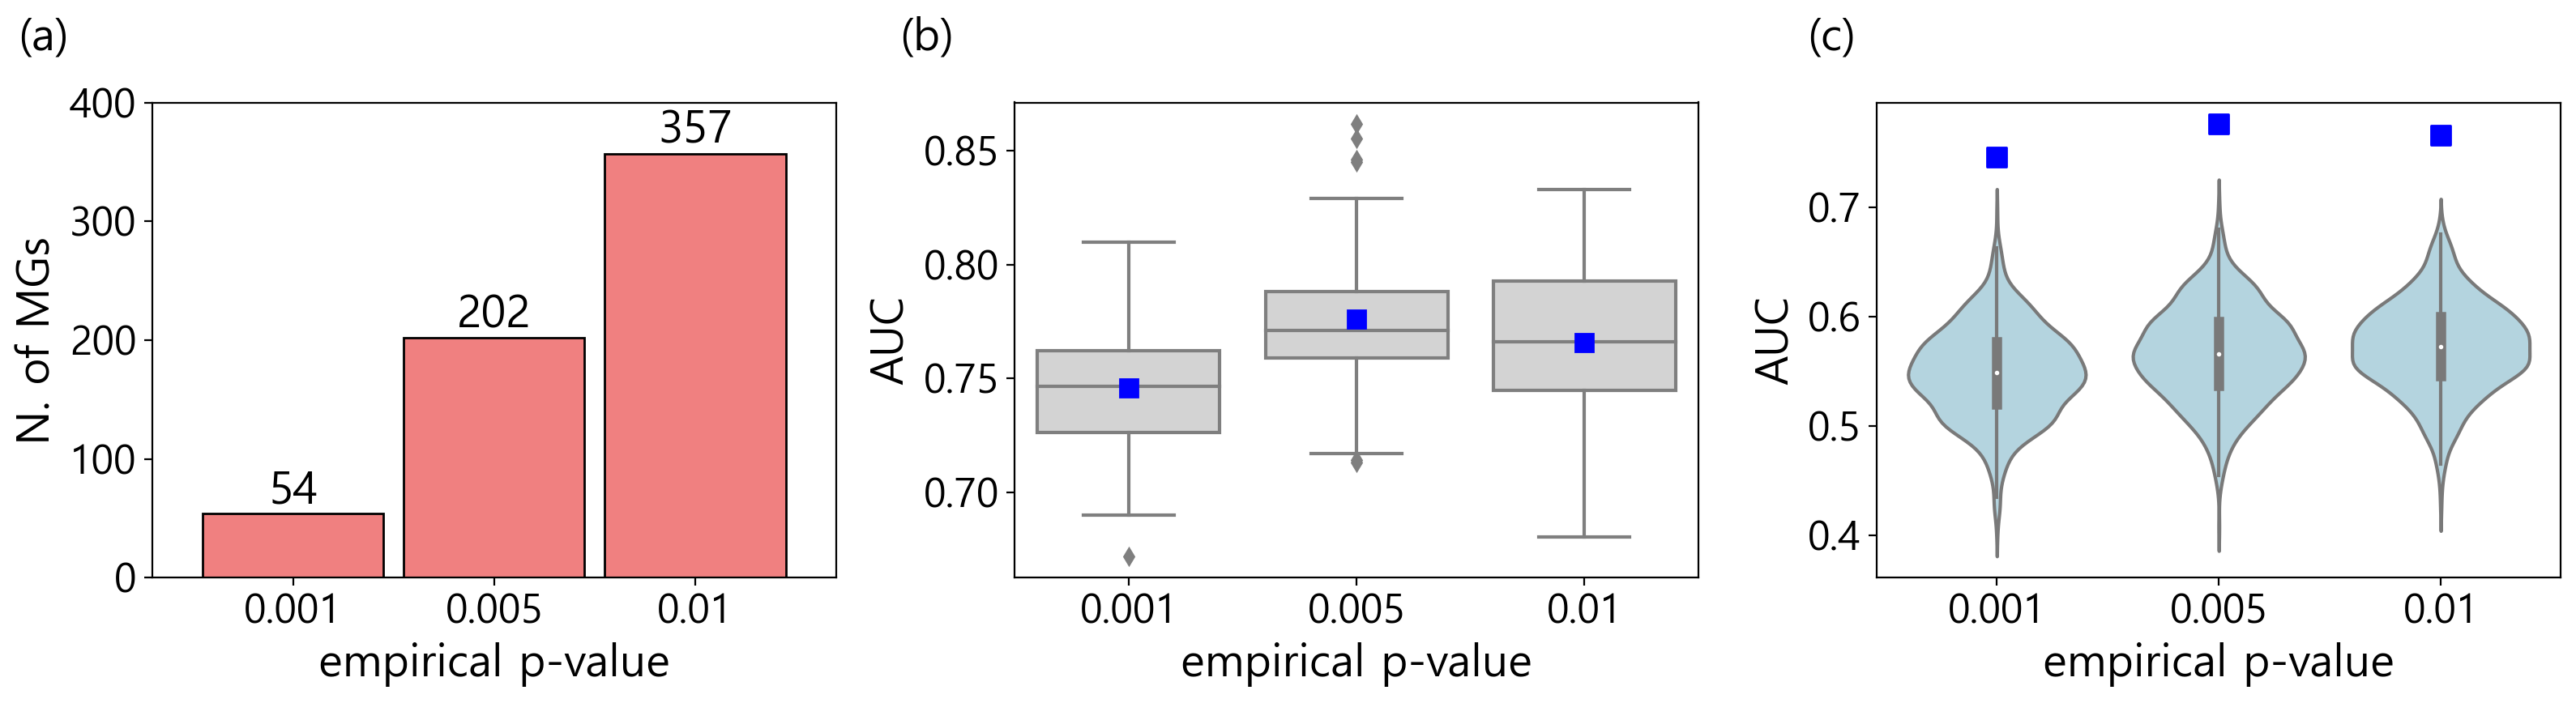

In [27]:
fig=plt.figure(figsize=(16,4), dpi=200)
axs=fig.subplots(1,3).flatten()

# ax0
all_nsig_df=pickle.load(open("../n_stage_pred_BRCA_0804toPC/main_result/BRCA_sig_info.pickle", 'rb'))
display_col_barplot(all_nsig_df, axs[0])

_=axs[0].tick_params(axis='both', labelsize=18)
_=axs[0].set_xlabel('empirical p-value', fontsize=20)
_=axs[0].set_ylabel('N. of MGs', fontsize=20)

# ax1
res_AUC_sigGenes=pickle.load(open('../n_stage_pred_BRCA_0804toPC/main_result/AUC_with_sigGenes.pickle', 'rb'))
AUC_mean=res_AUC_sigGenes.groupby('epval')['AUC'].mean()
AUC_mean
sns.boxplot(data=res_AUC_sigGenes, x='epval', y='AUC', showmeans=True, ax=axs[1], color='lightgrey',
            meanprops={"marker":"s","markerfacecolor":"blue", "markeredgecolor":"blue", 'markersize':8})

_=axs[1].tick_params(axis='both', labelsize=18)
_=axs[1].set_xlabel('empirical p-value', fontsize=20)
_=axs[1].set_ylabel('AUC', fontsize=20)

# ax2
res_AUC_ranGenes=pickle.load(open('../n_stage_pred_BRCA_0804toPC/main_result/AUC_with_ranGenes.pickle', 'rb'))
sns.violinplot(data=res_AUC_ranGenes, x='epval', y='AUC', ax=axs[2], color='lightblue')

_=axs[2].tick_params(axis='both', labelsize=18)
_=axs[2].set_xlabel('empirical p-value', fontsize=20)
_=axs[2].set_ylabel('AUC', fontsize=20)

for ii, auc in enumerate(AUC_mean.values):
    _=axs[2].scatter(ii, auc, marker="s",color="blue", s=80)#, "markeredgecolor":"blue", )

##
fig.text(0.01,1.02,'(a)', fontsize=20)
fig.text(0.35,1.02,'(b)', fontsize=20)
fig.text(0.70,1.02,'(c)', fontsize=20)

fig.tight_layout(h_pad=1.5, w_pad=1.5)